# Capstone: Detecting Aircraft from Satellite Imagery
## Part 3a - YOLOv7 Modelling
Using a pre-trained state of the art model suited to the task.
This part runs through the process of fine tuning the yolov7 model on the dataset that we have processed in parts 1 and 2.

---

In [1]:
import random
from PIL import Image, ImageDraw, ImageFont
import os
import numpy as np
from pathlib import Path

In [2]:
# set random seeds for reproducibility
random.seed(8888)
np.random.seed(8888)

## Clone YOLOv7 Repository as Required

In [3]:
# !git clone https://github.com/WongKinYiu/yolov7.git

## CD into YOLOv7 folder and install required libraries as required

In [4]:
%cd yolov7

C:\Users\User\Desktop\Capstone - Aircraft Detection\yolov7


In [5]:
# !pip install -r requirements.txt

Download the yolov7 model weights and place inside folder. Either through wget or manually from https://github.com/WongKinYiu/yolov7.

In [6]:
# !wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt

## Create Dataset File
YOLOv7 parses a yaml file to get data directories, number of classes and list of class names.

In [7]:
CONFIG = """
# train and val datasets (image directory or *.txt file with image paths)
train: data/images/train
val: data/images/val
test: data/images/test

# number of classes
nc: 1

# class names
names: ['Aircraft']
"""

with open("dataset.yaml", "w") as f:
    f.write(CONFIG)

## Run Training Script

Adjustable parameters:

1. The yolo labels and their respective images have been manually copied into a new working folder within the cloned yolov7 folder. These directories are specified in the 'dataset.yaml' file. 
Image augmentation is in-built into the training of the model, and these can be enabled or disabled. E.g. flipud - flip up or down, fliplr - flip left or right. fliplr and mosaic are 2 that are enabled by default.
    
2. Autoanchor enabled by default, Autoanchor will analyse your anchors against your dataset and training settings (like --img-size ), and will adjust anchors as necessary. This is a form of hyperparameter tuning. See this [medium article](https://towardsdatascience.com/training-yolo-select-anchor-boxes-like-this-3226cb8d7f0b) for explanation on anchors.

3. hyperparameter evolution can also be enabled (--evolve True) to allow auto tuning of hyperparameters.

For this iteration we will be running mostly on the vanilla settings of Yolov7. The arguments we will specify are batchsize (16), image size (512x512 as per training tile sizes), and **number of epochs (40)**. Workers will be set to 0, passing all the tasks to the faster GPU to run.

In [8]:
# !python train.py --img 512 --batch 16 --epochs 40 --data dataset.yaml --weights yolov7.pt --workers 0 --device 0 --name aircraft_detect --hyp data/hyp.scratch.custom.yaml

## Model Performance on Train and Validation Sets

### Losses
YOLO uses sum-squared error between predictions and ground truth to calculate loss. The loss function comprises:

- classification loss (errors in predicted class); in our case there is only one class so this is not applicable
- localization loss (errors between the predicted boundary box and the ground truth).
- confidence loss (the objectness of the box).  

source: [medium article by Jonathan Hui](https://jonathan-hui.medium.com/real-time-object-detection-with-yolo-yolov2-28b1b93e2088#:~:text=YOLO%20uses%20sum%2Dsquared%20error,box%20and%20the%20ground%20truth)  
*Metrics will be discussed later in evaluation.*

### Training Results

In [9]:
# load tensorboard within note book to get training logs
# %load_ext tensorboard
# %tensorboard --logdir runs/train

In [11]:
%cd ../

C:\Users\User\Desktop\Capstone - Aircraft Detection


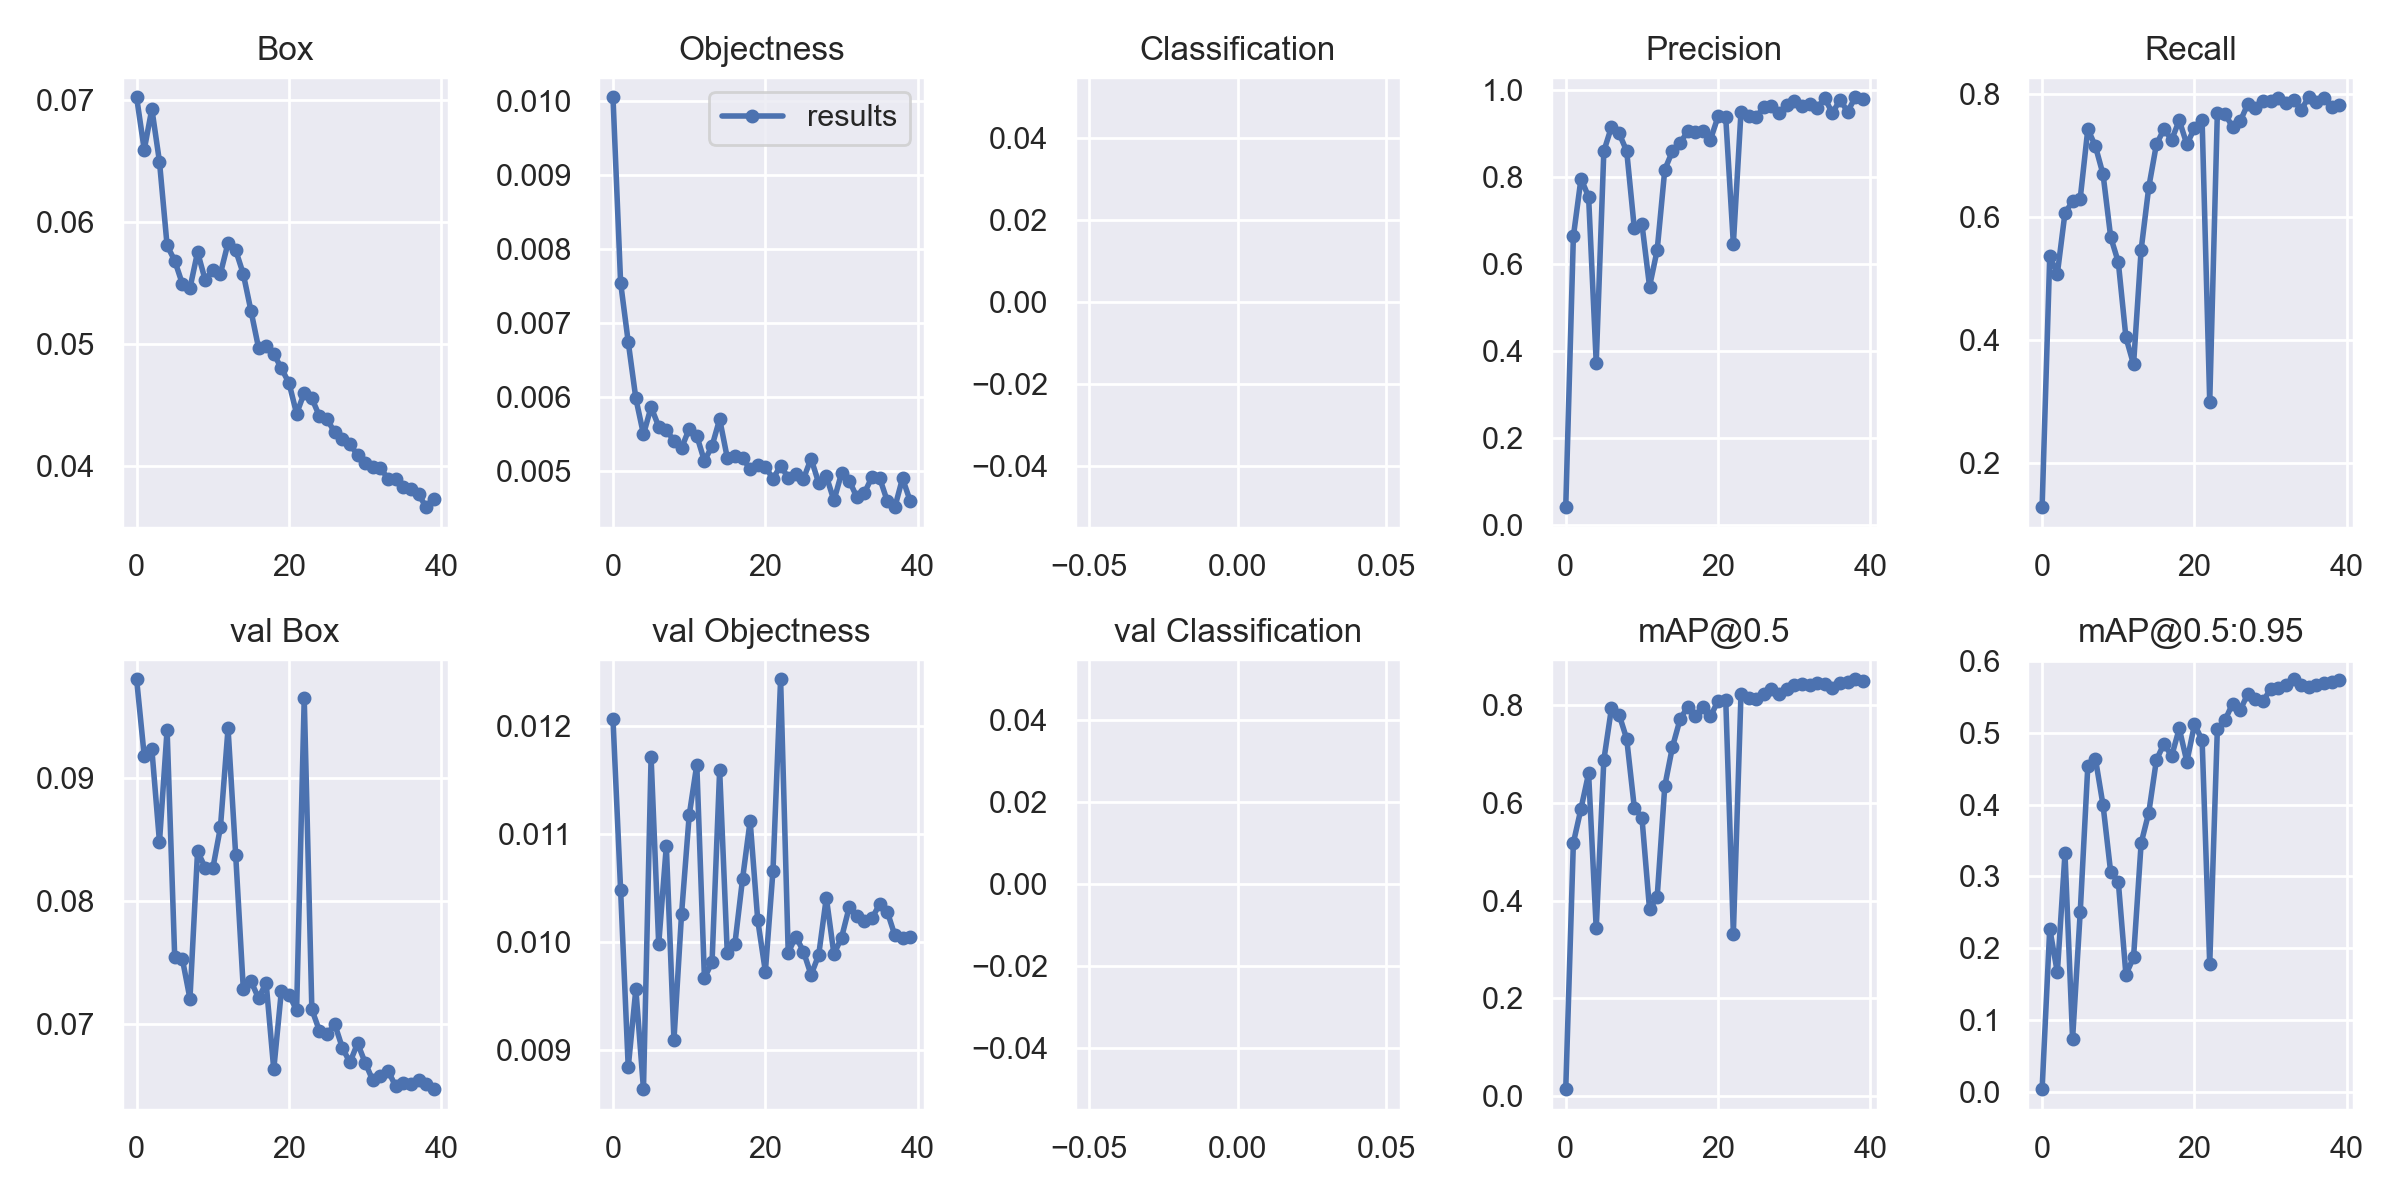

In [12]:
results = os.path.join('yolov7', 'runs', 'train', 'aircraft_detect', 'results.png')
graphs = Image.open(results)
display(graphs)

The 3 metrics: mAP, precision and recall were slightly turbulent for the first 25 epochs but trend upwards across all 40 epochs. No significant gain seen after approximately 30 epochs, suggesting that more training is unlikely to yield better performance for this model.

Train and validation loss functions generally decrease across the 40 epochs, except for validation obj_loss. validation obj_loss looks very turbulent but the value is actly quite stable around 0.0105.

### Train and Validation Scores - Best Saved Model

In [13]:
%cd yolov7

C:\Users\User\Desktop\Capstone - Aircraft Detection\yolov7


In [14]:
# val metrics and losses --batch 7
!python test.py --data dataset.yaml --img-size 512 --weights runs/train/aircraft_detect/weights/best.pt --name aircraft_detect --task val --device 0 --batch 7

Namespace(weights=['runs/train/aircraft_detect/weights/best.pt'], data='dataset.yaml', batch_size=7, img_size=512, conf_thres=0.001, iou_thres=0.65, task='val', device='0', single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='aircraft_detect', exist_ok=False, no_trace=False, v5_metric=False)
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

                 all         425         636       0.958       0.791       0.845       0.575
Speed: 7.1/1.0/8.1 ms inference/NMS/total per 512x512 image at batch-size 7
Results saved to runs\test\aircraft_detect


YOLOR  2023-1-23 torch 1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 8191.5625MB)

Model Summary: 306 layers, 36479926 parameters, 6194944 gradients, 103.2 GFLOPS

val: Scanning 'data\labels\val.cache' images and labels... 425 found, 0 missing, 201 empty, 0 corrupted: 100%|##########| 425/425 [00:00<?, ?it/s]
val: Scanning 'data\labels\val.cache' images and labels... 425 found, 0 missing, 201 empty, 0 corrupted: 100%|##########| 425/425 [00:00<?, ?it/s]

               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95:   0%|          | 0/61 [00:00<?, ?it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95:   2%|1         | 1/61 [00:00<00:28,  2.08it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95:   5%|4         | 3/61 [00:00<00:11,  5.27it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95:   8%|8         | 5/61 [00:

images: 425, targets: 636, precision: 0.958 recall: 0.791 mAP@.5: 0.845, map@.5-.95: 0.575

---
In the next notebook, training and validating YOLOv8